# Homework 3: Exploration in RL (due 11:59PM, April 5th, 2024)

In this homework, you will implement and compare a number of exploration strategies.

## Problem 1 (2 points)

Implement a **combination lock MDP** of length H = 20, number of actions A = 10, number of states per step = 3. Denote the states as $\{s_{h;1}, s_{h;2}, s_{h;3}\}_{h=1:20}$. While initializing the MDP, uniformly randomly choose one out of ten actions for each stage as the **good action**, denoted as $\{a^*_h\}_{h=1:20}$. Define the transition as: 

$$P(s_{h+1;1}|s_{h;1},a^*_h)=P(s_{h+1;2}|s_{h;1},a^*_h)=P(s_{h+1;1}|s_{h;2},a^*_h)=P(s_{h+1;2}|s_{h;2},a^*_h)=0.5$$
while for $a\neq a^*_h$,
$$P(s_{h+1;3}|s_{h;1},a)=P(s_{h+1;3}|s_{h;2},a)=P(s_{h+1;3}|s_{h;3},a)=1$$
Lastly, if you are in the bad state, for any action $a$,
$$P(s_{h+1;3}|s_{h;3},a)=1$$
In terms of rewards, the agent receives a reward of 10 upon reaching $s_{H,1}$ or $s_{H,2}$, at which point the episode will also reset. Otherwise the reward will always be 0.

**************************************************************************************************************
**************************************************************************************************************
### My Notes
1. 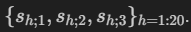 <- there are 3 states per step, and each state ranges from 1-20.
1. 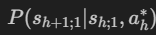 = the probability of transitioning from state $s_{h;1}$ to $s_{h+1;1}$ given the good action is taken.
2. 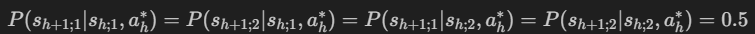 <- shows that the probability of going from one state to another is the same regardless of whether we consider all past states or only a portion of them.
3. 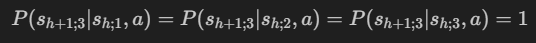 <- shows that regardless of previous sets of actions taken, the probability of transitioning to the next sequence of states is always 1.
4. 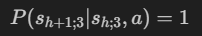 <- if you are in a bad state, the probability of transitioning to the next state is always 1.
**************************************************************************************************************
### MDP Steps
- At each step h, the agent can choose one action from the set of 10 possible actions.
- Only one action at each step leads to the optimal path (the "good action").
- The sequence of good actions from step 1 to step 20 can be thought of as the combination to the "lock."
**************************************************************************************************************
### Definitions
- A **good state** is a state that returns a high amount of reward. 
- A **bad state** is a state that returns a low amount of reward.

In [24]:
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import random
from collections import deque, namedtuple 
import numpy as np
import matplotlib.pyplot as plt

In [31]:
class CombLockMDP(gym.Env):
    """
    Methods:
        reset(): Resets the environment to the starting state.
        step(action): Takes a step in the environment.
    """

    def __init__(self, H=20, A=10, S=3, R=10, seed=0):
        ## Fill in here
        ## use the seed input as the random seed when generating the good actions.
        
        self.H = H  # horizon
        self.A = A  # Number of actions
        self.S = S  # Number of states per step
        self.R = R  # Reward
        self.seed = seed 
        self.np_random = np.random.RandomState(self.seed)
        
        # Generate a set of 10 good actions for each step
        self.good_actions = self.np_random.choice(self.A, self.H)

        # Initialize the current state
        self.current_state = 0
        self.current_step = 0

    def reset(self, bool):
        
        ## Fill in here
        self.current_state = np.random.randint(0, self.S)
        self.current_step = 0
        if bool:
            return np.array(self.current_state)
        else:
            self.current_state = 0

    def step(self, action):
        # Check if the action is the set of "good" actions
        if action == self.good_actions[self.current_step]:
            # If at the last step and the action is good, receive reward and reset
            if self.current_step == self.H - 1:
                reward = self.R
                self.current_state = 0
                self.current_step = 0
                done = True
            # If not at the last step, simply move to the next step
            else:
                reward = 0
                self.current_state += 1
                self.current_step += 1
                done = False
        else:
            # If the action is not good, move to the bad state of this step
            self.current_state = self.current_step * self.S + (self.S - 1)
            reward = 0
            done = True  # End the episode if the wrong action is taken

        return np.array(self.current_state), reward, done, {}

## Problem 2 (2 points)

Implement the UCBVI algorithm with reward bonus $b_h(s,a)=\alpha\sqrt{1/N_h(s,a)}$, where $\alpha$ is a hyperparameter that you will tune.

Run UCBVI in the combination lock MDP (with turned $\alpha$) and plot its learning curve: Cumulative reward v.s. training episode same as in HW2.

In [32]:
import numpy as np

class UCBVI(object):
    def __init__(self, action_space, alpha=1):
        self.alpha = alpha
        self.action_space = action_space
        self.q_values = {}  # Using a dict to store Q-values, initialized as needed
        self.counts = {}    # Using a dict to store counts, initialized as needed

    def update(self, state, action, reward, next_state, done):
        # Initialize Q-value and count if encountering a new state-action pair
        if (state, action) not in self.q_values:
            self.q_values[(state, action)] = 0
            self.counts[(state, action)] = 0

        # Update count
        self.counts[(state, action)] += 1

        # Compute the bonus
        bonus = self.alpha / np.sqrt(self.counts[(state, action)])

        # Assume 0 for Q-value of the next state if 'done' flag is True or next_state is new
        q_next = max([self.q_values.get((next_state, a), 0) for a in range(self.action_space)]) if not done else 0
        
        # Update the Q-value with the standard Q-learning update rule
        self.q_values[(state, action)] += (reward + bonus + q_next - self.q_values[(state, action)]) / self.counts[(state, action)]

    def action(self, state):
        # Here we assume that 'self.action_space' is available or somehow defined
        q_values_with_bonus = {a: self.q_values.get((state, a), 0) + self.alpha / np.sqrt(self.counts.get((state, a), 1))
                               for a in range(self.action_space)}
        
        # Select the action with the highest Q-value + bonus
        return max(q_values_with_bonus, key=q_values_with_bonus.get)


Complete


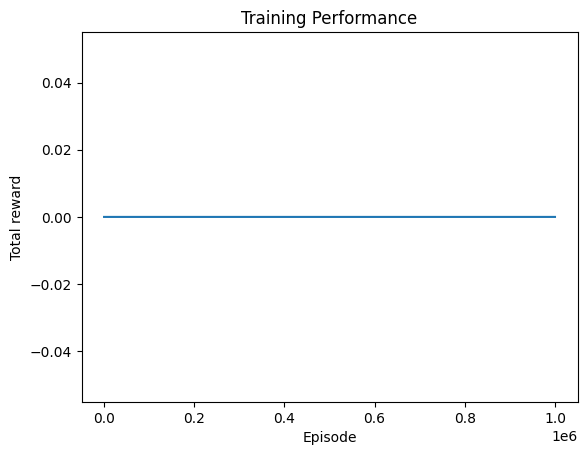

In [34]:
# Training loop: use a large enough num_episodes that make the algorithm converge.
num_episodes = 1000000

# Create an instance of the environment
env = CombLockMDP()

# Create an instance of UCBVI
# remember to tune your alpha!!!

alpha = 0.1
agent = UCBVI(env.A, alpha) 

total_rewards = np.zeros(num_episodes)

for i_episode in range(num_episodes):
    state = env.reset(bool=False)
    for h in range(env.H):
        action = agent.action(state)
        next_state, reward, done, _ = env.step(action)
        total_rewards[i_episode] += reward
        agent.update(state,action,next_state,reward, done)
        state = next_state
        if done:
            break

print('Complete')
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.title('Training Performance')
plt.show()

## Problem 3 (2 points)

Implement DQN with $\epsilon$-greedy, where $\epsilon$ is a hyperparameter that you will tune. (You should have already have this code from HW2!)

Run DQN+$\epsilon$-greedy in the combination lock MDP (with turned $\epsilon$) and plot its learning curve: Cumulative reward v.s. training episode same as in HW2.

In [ ]:
def discounted_cumsum(x: np.ndarray, gamma: float) -> np.ndarray:
    cumsum = np.zeros_like(x)
    cumsum[-1] = x[-1]
    for t in reversed(range(x.shape[0] - 1)):
        cumsum[t] = x[t] + gamma * cumsum[t + 1]
    return cumsum

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        state = torch.relu(self.fc1(state))
        return self.fc2(state)


class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)


class DQNAgent:
    def __init__(self, state_size, action_size, hidden_size, 
                 buffer_size, batch_size, update_every,
                 learning_rate, gamma, tau, device, use_duoble_dqn=False):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.update_every = update_every
        self.gamma = gamma
        self.tau = tau
        self.device = device
        self.update_steps = 0
        self.use_duoble_dqn = use_duoble_dqn

        self.q = QNetwork(state_size, action_size, hidden_size).to(device)
        self.q_targ = QNetwork(state_size, action_size, hidden_size).to(device)
        self.optimizer = optim.Adam(self.q.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size, batch_size)
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        
    def train(self):
        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences)
        
        if (self.update_steps + 1) % self.update_every == 0:
            self.soft_update()

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.q.eval()
        with torch.no_grad():
            action_values = self.q(state)
        self.q.train()
 
        if random.random() > eps:
            return np.argmax(action_values.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        # print(states.shape, actions.shape)
        criterion = nn.MSELoss()
        self.optimizer.zero_grad()

        # Get expected Q values from local model
        Q_expected = self.q(states).gather(1, actions)

        # Get max predicted Q values (for next states) from target model
        if not self.use_duoble_dqn:
            Q_targets_next = self.q_targ(next_states).max(1)[0].unsqueeze(1)
        else:
            Q_local_max_actions = self.q(next_states).max(1)[1].unsqueeze(1)
            Q_targets_next = self.q_targ(next_states).gather(1, Q_local_max_actions)

        # Compute Q targets for current states 
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))


        # Compute loss
        loss = criterion(Q_expected, Q_targets)
        loss.backward()
        self.optimizer.step()        
        self.update_steps += 1

    def soft_update(self):
        for target_param, local_param in zip(self.q_targ.parameters(), self.q.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

In [ ]:
epochs = 100
steps_per_epoch = 20
save_every = 50
eval_every = 10
eval_rollout = 10
buffer_size = 10000
update_every = 100
max_len = 20           ## self.H
batch_size = 128
state_size = 1         ## 
action_size = 10       ## self.A
hidden_size = 256
learning_rate = 1e-3
eps = 0.7
tau = 0.995
gamma = 0.9
device = "cpu"
seeds = [0, 11, 22, 33, 44, 55, 66, 77, 88, 99]
seed = seeds[0]

eps_start = 1.0    # starting value of epsilon
eps_end = 0.01     # minimum value of epsilon
eps_decay = 0.995  # multiplicative factor (per episode) for decreasing epsilon

eval_rew_list = []
for seed in seeds:
    random.seed(seed)
    torch.manual_seed(seed)

    # replaybuffer = ReplayBuffer(buffer_size, batch_size)
    agent = DQNAgent(state_size, action_size, hidden_size, 
                    buffer_size, batch_size, update_every,
                    learning_rate, gamma, tau, device)
    env = CombLockMDP()### CHANGED ####

    # Training loop
    # eps = eps_start
    eps = 0.5
    eval_rew = []
    for i in range(epochs):
        state = env.reset()
        for t in range(max_len):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            if done:
                break
        # Decrease epsilon
        # eps = max(eps_end, eps_decay*eps)
        # eps = 0.5
        # eps = eps_start - (eps_start-eps_end)/total_steps * agent.update_steps
        
        for _ in range(steps_per_epoch):
            agent.train()
        
        if (i + 1) % eval_every == 0:
            scores = []
            while len(scores) < eval_rollout:
                state = env.reset(bool=True)
                done = False
                score = []
                for t in range(max_len):
                    action = agent.act(state, eps=0.0)
                    next_state, reward, done, _ = env.step(action)
                    score.append(reward)
                    state = next_state
                    # Exit loop if episode finished
                    if done:
                        break
                score = discounted_cumsum(np.array(score), gamma)[0]
                scores.append(score)
            eval_rew.append(np.mean(scores))
            print(f"Epoch {i+1}\tAverage Score: {np.mean(scores)}\teps = {eps}")

        if (i + 1) % save_every == 0:
            torch.save(agent.q.state_dict(), f'checkpoint_episode_{i + 1}.pth')

    print("Training completed.")
    eval_rew_list.append(np.array(eval_rew))

KeyboardInterrupt: 

## Problem 4 (3 points)

Implement DQN with RND using a randomly neural network as the target network $f:S\rightarrow \mathbb{R}^d$, and use the reward bonus in the form of $\alpha||\hat{f}(s)-f(s)||_2^2$. 

Run DQN+RND in the combination lock MDP (with turned hyperparameters, including $\alpha$, the replay buffer size, learning rates, etc) and plot its learning curve: Cumulative reward v.s. training episode same as in HW2.

An example implementation of DQN+RND can be found [here](https://github.com/orrivlin/MountainCar_DQN_RND).

In [ ]:
## Your code goes here

## Problem 5 (1 points)

Plot the performance curve of UCBVI, DQN with $\epsilon$-greedy, and DQN+RND in the same figure.

In [ ]:
## Your code goes here